## make_blobs
make_blobs는 가우시안(등방성) 분포의 가짜 데이터 군집을 생성하는 유틸리티

In [11]:
# Step 10: make_blobs로 인공 데이터 생성
from sklearn.datasets import make_blobs
import numpy as np

X, y = make_blobs(
    n_samples=200,
    n_features=2,
    centers=3,
    cluster_std=0.8,
    random_state=0
)
print(X.shape, y.shape)
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

(200, 2) (200,)
[0 1 2] [67 67 66]


In [12]:
# Step 11: DataFrame 변환 및 확인
import pandas as pd
cluster_df = pd.DataFrame(data=X, columns=["ftr1", "ftr2"])
cluster_df["target"] = y
cluster_df.head()

,ftr1,ftr2,target
0,-1.692427,3.622025,2
1,0.697940,4.428867,0
2,1.100228,4.606317,0
3,-1.448724,3.384245,2
4,1.214861,5.364896,0


In [13]:
# Step 12: KMeans 학습 및 라벨 할당
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init="k-means++", max_iter=200, random_state=13)
cluster_labels = kmeans.fit_predict(X)
cluster_df["kmeans_label"] = cluster_labels
cluster_df.head()

,ftr1,ftr2,target,kmeans_label
0,-1.692427,3.622025,2,1
1,0.697940,4.428867,0,0
2,1.100228,4.606317,0,0
3,-1.448724,3.384245,2,1
4,1.214861,5.364896,0,0


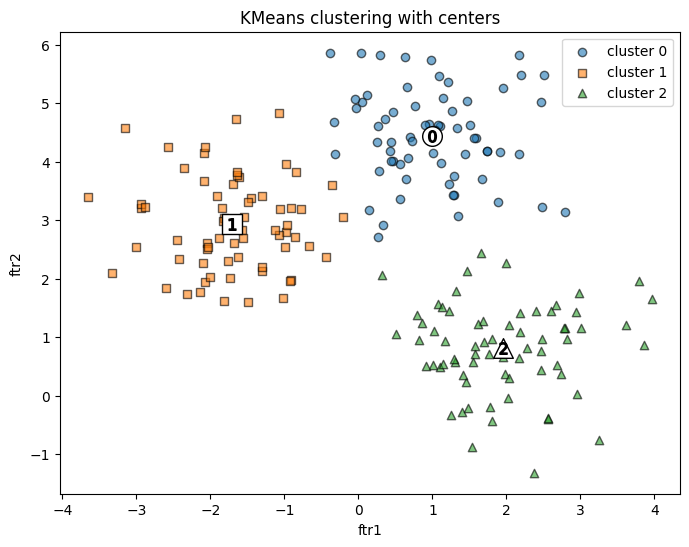

In [14]:
# Step 13: 군집별 산점도와 중심 표시
import matplotlib.pyplot as plt
import numpy as np
centers = kmeans.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ["o", "s", "^", "P", "D", "H", "x"]

plt.figure(figsize=(8,6))
for label in unique_labels:
    label_cluster = cluster_df[cluster_df["kmeans_label"] == label]
    center_x_y = centers[int(label)]
    plt.scatter(x=label_cluster["ftr1"], y=label_cluster["ftr2"], edgecolor="k", marker=markers[int(label)], alpha=0.6, label=f"cluster {int(label)}")
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color="white", edgecolor="k", marker=markers[int(label)])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color="k", marker="$%d$" % label)

plt.legend()
plt.xlabel('ftr1')
plt.ylabel('ftr2')
plt.title('KMeans clustering with centers')
plt.show()

In [15]:
# Step 14: 그룹별 kmeans_label 분포 확인
print(cluster_df.groupby("target")["kmeans_label"].value_counts())

target  kmeans_label
0       0               66
        1                1
1       2               67
2       1               65
        2                1
Name: count, dtype: int64


## 군집 결과의 평가
다음으로 실루엣 점수로 군집화 품질을 확인합니다.

In [16]:
# Step 15: Iris 데이터 로드 및 KMeans 적용 (비교용)
# Step 15-1: Iris 데이터셋을 로드하는 함수 임포트
from sklearn.datasets import load_iris
# Step 15-2: KMeans 군집화 알고리즘 클래스 임포트
from sklearn.cluster import KMeans
# Step 15-3: DataFrame 생성/처리를 위한 pandas 임포트
import pandas as pd

# Step 15-4: Iris 데이터셋을 메모리로 로드 (iris.data, iris.target 포함)
iris = load_iris()
# Step 15-5: 데이터프레임 컬럼 이름 정의
feature_names = ["sepal length", "sepal width", "petal length", "petal width"]
# Step 15-6: numpy 배열을 pandas DataFrame으로 변환
iris_df = pd.DataFrame(data=iris.data, columns=feature_names)
# Step 15-7: KMeans 모델을 학습시켜 클러스터 라벨을 생성
kmeans_iris = KMeans(n_clusters=3, init="k-means++", max_iter=300, random_state=0).fit(iris_df)


In [17]:
# Step 16: Iris KMeans 라벨 추가
iris_df["cluster"] = kmeans_iris.labels_
iris_df.head()

,sepal length,sepal width,petal length,petal width,cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [18]:
# Step 17: 실루엣 점수 계산
# Step 17-1: 실루엣 지표를 계산하기 위한 함수 임포트 (샘플 단위와 전체 평균을 구함)
from sklearn.metrics import silhouette_samples, silhouette_score

# Step 17-2: 전체 데이터에 대한 평균 실루엣 점수 계산 — 군집화 품질의 전반적 지표
avg_value = silhouette_score(iris.data, iris_df["cluster"])

# Step 17-3: 각 샘플 별 실루엣 값 계산 — 클러스터 내부 응집도와 이웃 클러스터와의 분리도 확인
score_values = silhouette_samples(iris.data, iris_df["cluster"])

# Step 17-4: 결과 출력 — 평균값, 반환 배열의 형태와 처음 10개 샘플의 실루엣 값 확인
print("avg_value:", avg_value)
print("silhouette_samples() return shape:", score_values.shape)
print("first 10 silhouette values:", score_values[:10])

avg_value: 0.551191604619592
silhouette_samples() return shape: (150,)
first 10 silhouette values: [0.85258191 0.8149163  0.82879659 0.80435199 0.84891774 0.7477614
 0.82109757 0.8534934  0.75127806 0.82475199]


In [19]:
# Step 18: 실루엣 시각화 함수 정의
# Step 18-1: 함수 목적 - 서로 다른 k(클러스터 수)에 대해 KMeans를 적용하고 각 샘플의 실루엣 분포를 시각화.
def visualize_silhouette(cluster_lists, X_features):
    # Step 18-2: 필요한 라이브러리 로컬 임포트 (노트북 셀 단위 실행 시 의존성 보장)
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    # Step 18-3: 전달받은 여러 클러스터 수에 대해 subplot을 만들기 위한 설정
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)
    # Step 18-4: 각 클러스터 수별로 KMeans를 실행하고 실루엣 점수(평균 및 샘플)를 계산하여 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        # 18-4a: KMeans로 라벨 예측
        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        # 18-4b: 전체 평균 실루엣 점수와 각 샘플의 실루엣 값 계산
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        # 18-4c: 각 클러스터 블록의 y축 시작 위치 초기화
        y_lower = 10
        # 18-5: 서브플롯 제목/축 라벨/범위 설정
        axs[ind].set_title("Number of Cluster : " + str(n_cluster) + "\n" + "Silhouette Score :" + str(round(sil_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # y축 레이블 제거
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # Step 18-6: 각 클러스터에 대해 샘플 실루엣값을 정렬해 막대(수평) 형태로 그리기
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_sil_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            # 클러스터 라벨 표시 및 다음 블록으로 y_lower 갱신
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        # Step 18-7: 평균 실루엣 점수를 세로선으로 표시
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")
    # Step 18-8: 레이아웃 조정 및 표시
    plt.tight_layout()
    plt.show()

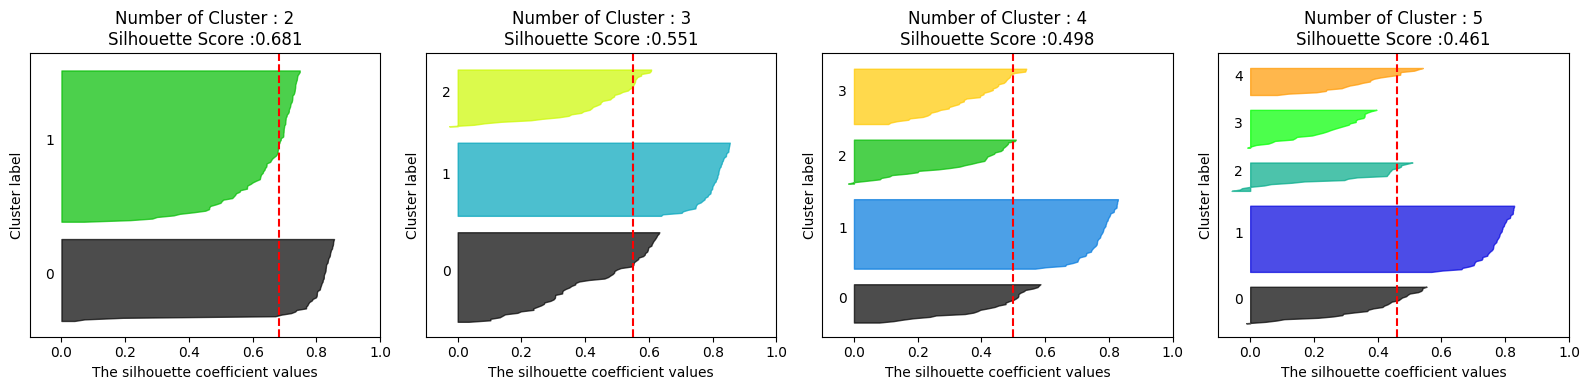

In [ ]:
# Step 19: visualize_silhouette 호출 — 여러 k에 대한 실루엣 분포를 한 번에 그려 비교함
# Step 19-1: cluster_lists = [2,3,4,5] → k=2,3,4,5를 비교하기 위해 여러 k값을 전달
# Step 19-2: X_features로 iris.data(원본 특성 행렬)를 전달 → 각 k에 대한 실루엣 분포 계산에 사용
visualize_silhouette([2, 3, 4, 5], iris.data)


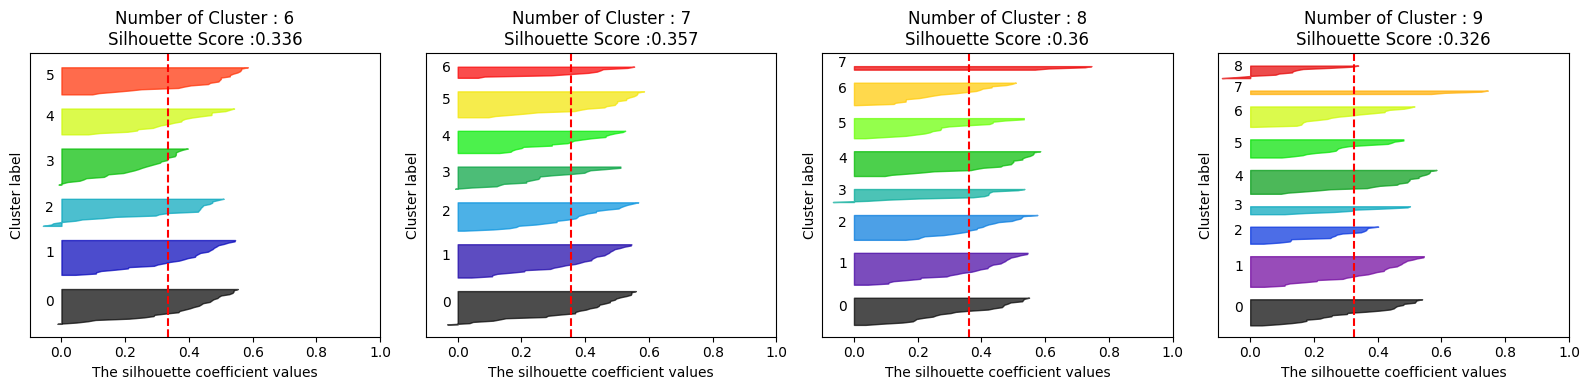

In [21]:
visualize_silhouette([6, 7, 8, 9], iris.data)